In [1]:
import os
import glob as gb
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    classification_report
)
from tensorflow.keras.models import load_model


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score
)
from tensorflow.keras.applications import (
    ResNet50, ResNet101, EfficientNetB0, VGG16
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

In [2]:
train_path = "../Data_f/seg_train"
test_path = "../Data_f/seg_test"

In [3]:
def count_images_in_path(directory_path):
    return sum(len(files) for root, _, files in os.walk(directory_path) if root != directory_path)

train_images = count_images_in_path(train_path)
test_images = count_images_in_path(test_path)

print(f"Total images in -> Train: {train_images}")
print(f"Total images in -> Test: {test_images}")

Total images in -> Train: 14034
Total images in -> Test: 3000


In [4]:
def count_in_each_folder(path):
    for folder in os.listdir(path):
        # Skip .DS_Store
        if folder.startswith('.'):
            continue

        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path): 
            file_count = len(gb.glob(os.path.join(folder_path, "*.jpg")))
            print(f"Found {file_count} .jpg files in folder '{folder}'")

print("TRAIN FOLDER COUNT:")
count_in_each_folder(train_path)

print("\nTEST FOLDER COUNT:")
count_in_each_folder(test_path)

TRAIN FOLDER COUNT:
Found 2271 .jpg files in folder 'forest'
Found 2191 .jpg files in folder 'buildings'
Found 2404 .jpg files in folder 'glacier'
Found 2382 .jpg files in folder 'street'
Found 2512 .jpg files in folder 'mountain'
Found 2274 .jpg files in folder 'sea'

TEST FOLDER COUNT:
Found 474 .jpg files in folder 'forest'
Found 437 .jpg files in folder 'buildings'
Found 553 .jpg files in folder 'glacier'
Found 501 .jpg files in folder 'street'
Found 525 .jpg files in folder 'mountain'
Found 510 .jpg files in folder 'sea'


In [5]:
import os
import glob as gb
import matplotlib.pyplot as plt

def count_in_each_folder(path):
    folder_counts = {}
    for folder in os.listdir(path):
        if folder.startswith('.'):
            continue

        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path): 
            file_count = len(gb.glob(os.path.join(folder_path, "*.jpg")))
            print(f"Found {file_count} .jpg files in folder '{folder}'")
            folder_counts[folder] = file_count
    return folder_counts
print("TRAIN")
train_counts = count_in_each_folder(train_path)
print()
print("TEST")
test_counts = count_in_each_folder(test_path)


fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # 1 row, 2 columns

axes[0].pie(train_counts.values(), labels=train_counts.keys(), autopct='%1.1f%%', startangle=90)
axes[0].set_title("Distribution of Images in Train Folders")

axes[1].pie(test_counts.values(), labels=test_counts.keys(), autopct='%1.1f%%', startangle=90)
axes[1].set_title("Distribution of Images in Test Folders")

plt.tight_layout()
plt.show()


TRAIN
Found 2271 .jpg files in folder 'forest'
Found 2191 .jpg files in folder 'buildings'
Found 2404 .jpg files in folder 'glacier'
Found 2382 .jpg files in folder 'street'
Found 2512 .jpg files in folder 'mountain'
Found 2274 .jpg files in folder 'sea'

TEST
Found 474 .jpg files in folder 'forest'
Found 437 .jpg files in folder 'buildings'
Found 553 .jpg files in folder 'glacier'
Found 501 .jpg files in folder 'street'
Found 525 .jpg files in folder 'mountain'
Found 510 .jpg files in folder 'sea'


In [6]:
import os
import glob
import matplotlib.pyplot as plt

def get_image_sizes(base_path):
    sizes = []
    for subfolder in os.listdir(base_path):
        subfolder_path = os.path.join(base_path, subfolder)
        image_files = glob.glob(os.path.join(subfolder_path, "*.jpg"))
        sizes.extend([plt.imread(image).shape for image in image_files])
    return sizes

train_image_sizes = get_image_sizes(train_path)
test_image_sizes = get_image_sizes(train_path)


In [7]:
pd.Series(train_image_sizes).value_counts()

(150, 150, 3)    13986
(113, 150, 3)        7
(135, 150, 3)        3
(111, 150, 3)        3
(134, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(144, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(136, 150, 3)        2
(108, 150, 3)        2
(119, 150, 3)        1
(81, 150, 3)         1
(100, 150, 3)        1
(141, 150, 3)        1
(145, 150, 3)        1
(131, 150, 3)        1
(103, 150, 3)        1
(147, 150, 3)        1
(102, 150, 3)        1
(97, 150, 3)         1
(110, 150, 3)        1
(120, 150, 3)        1
(115, 150, 3)        1
(105, 150, 3)        1
(76, 150, 3)         1
(149, 150, 3)        1
(124, 150, 3)        1
(133, 150, 3)        1
(140, 150, 3)        1
Name: count, dtype: int64

In [8]:
max_size = max(train_image_sizes, key=lambda x: x[0] * x[1])  
print(f"Maximum size: {max_size}")

Maximum size: (150, 150, 3)


In [9]:
max_size = max(test_image_sizes, key=lambda x: x[0] * x[1])  
print(f"Maximum size: {max_size}")

Maximum size: (150, 150, 3)


In [10]:
categories = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
encode = {category: idx for idx, category in enumerate(categories)}
decode = categories 
n_classes = len(categories)
image_size = (150, 150)

In [11]:
print(encode)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [12]:
def preprocess_images(data_path, label_mapping = encode, img_size = (150,150)):
    images = []
    labels = []
    
    for class_folder in os.listdir(data_path):
        if class_folder == '.DS_Store':  
            continue
        
        class_label = label_mapping[class_folder]  
        folder_path = os.path.join(data_path, class_folder)

        for image_file in tqdm(os.listdir(folder_path), desc=f"Processing {class_folder}"):
            image_path = os.path.join(folder_path, image_file)
            
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, img_size)
            
            images.append(image)
            labels.append(class_label)

    images = np.array(images, dtype = "float32")
    labels = np.array(labels, dtype ="int8")

    return images, labels

def load_dataset(train_path, test_path, label_mapping, img_size = (150,150)):
    print("\nTraining Data Loading: ")
    train_images, train_labels = preprocess_images(train_path, label_mapping, img_size)

    print("\nTesting Data Loading: ")
    test_images, test_labels = preprocess_images(test_path, label_mapping, img_size)

    return train_images, train_labels, test_images, test_labels


train_images, train_labels, test_images, test_labels = load_dataset(train_path,test_path,encode,image_size)


Training Data Loading: 


Processing sea: 100%|█████████████████████| 2274/2274 [00:00<00:00, 7522.30it/s]



Testing Data Loading: 


Processing sea: 100%|███████████████████████| 510/510 [00:00<00:00, 3616.00it/s]


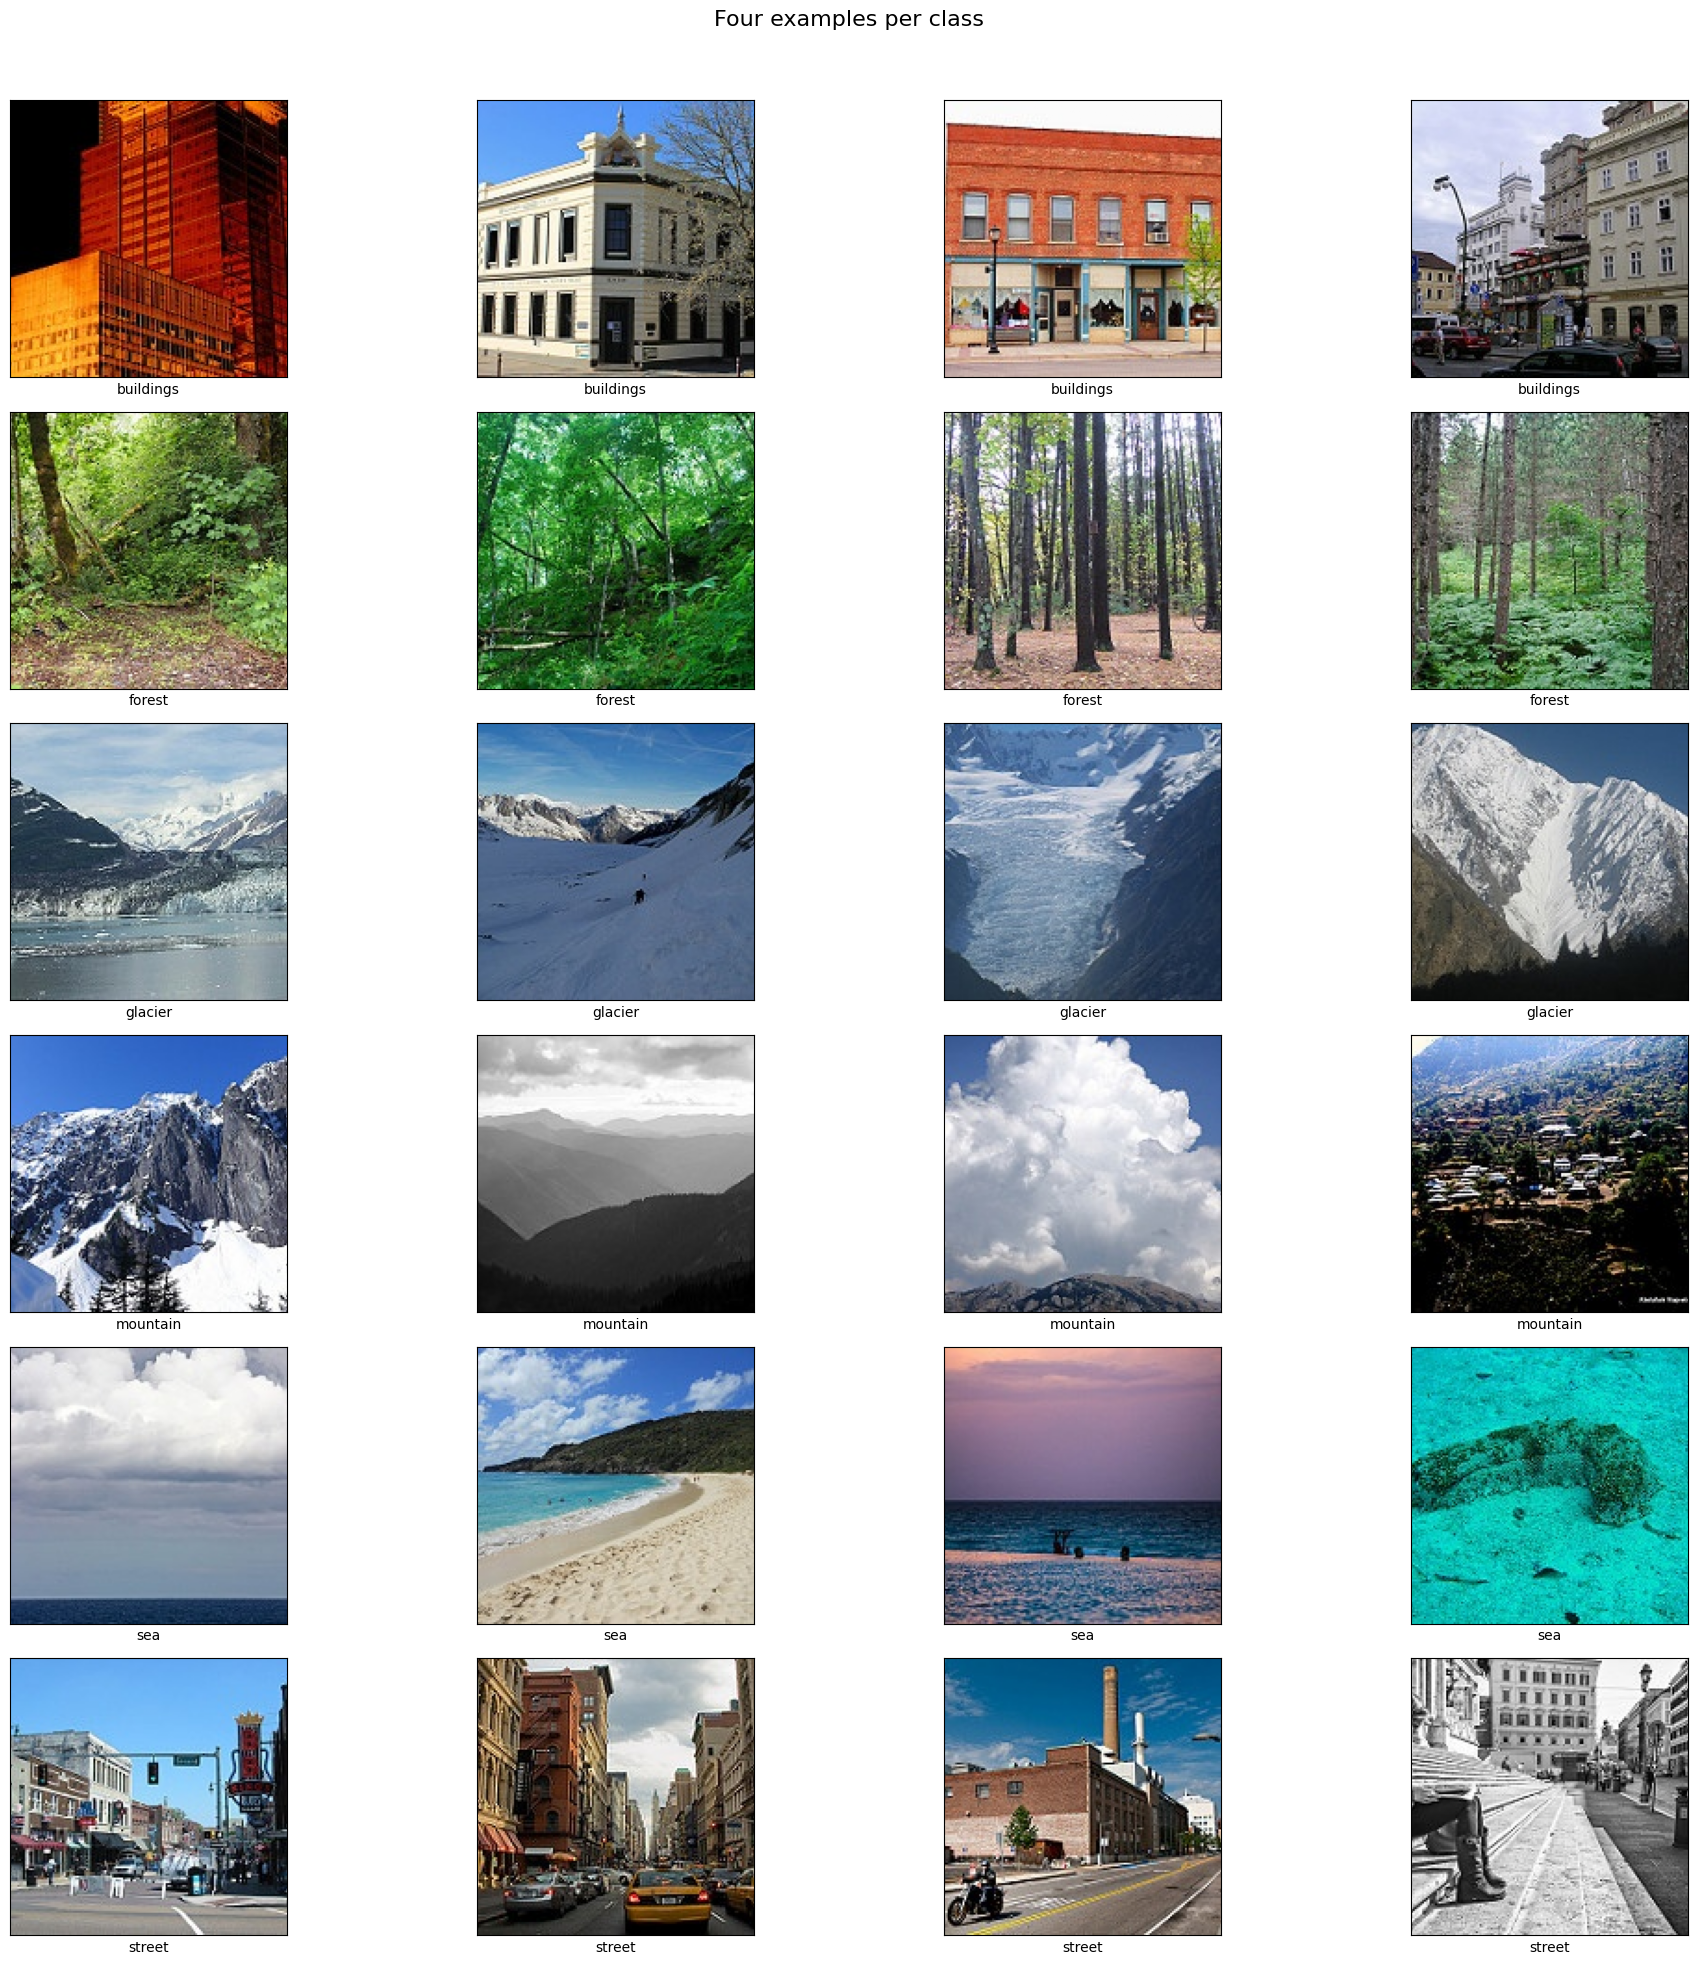

In [13]:
def display_examples(images, labels, label_mapping):
    reverse_mapping = {v: k for k, v in label_mapping.items()}
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle("Four examples per class", fontsize=16)

    unique_labels = np.unique(labels)
    x = 1

    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        selected_indices = np.random.choice(label_indices, 4, replace=False)

        for idx in selected_indices:
            plt.subplot(len(unique_labels), 4, x)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[idx] / 255, cmap=plt.cm.binary)
            plt.xlabel(reverse_mapping[label])
            x += 1

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

display_examples(train_images, train_labels, encode)

### SPLITTING DATA

In [15]:
X_train, y_train, X_test, y_test = train_images, train_labels, test_images, test_labels

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14034, 150, 150, 3), (14034,), (3000, 150, 150, 3), (3000,))

In [17]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [18]:
X_train_split.shape, X_val_split.shape, y_train_split.shape, y_val_split.shape

((11227, 150, 150, 3), (2807, 150, 150, 3), (11227,), (2807,))

In [19]:
def shuffle_data(X, y):
    idx = np.random.permutation(X.shape[0])
    return X[idx], y[idx]

X_train_split, y_train_split = shuffle_data(X_train_split, y_train_split)
X_val_split, y_val_split = shuffle_data(X_val_split, y_val_split)
X_test, y_test = shuffle_data(X_test, y_test)

In [20]:
# y_val_split

### AUGMENTATION

In [22]:
train_datagen = ImageDataGenerator( 
    rotation_range=20,    
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,      
    zoom_range=0.2,       
    horizontal_flip=True,
)
val_test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_split, y_train_split, batch_size=32, shuffle=True)
val_generator = val_test_datagen.flow(X_val_split, y_val_split, batch_size=32, shuffle=False)
test_generator = val_test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)



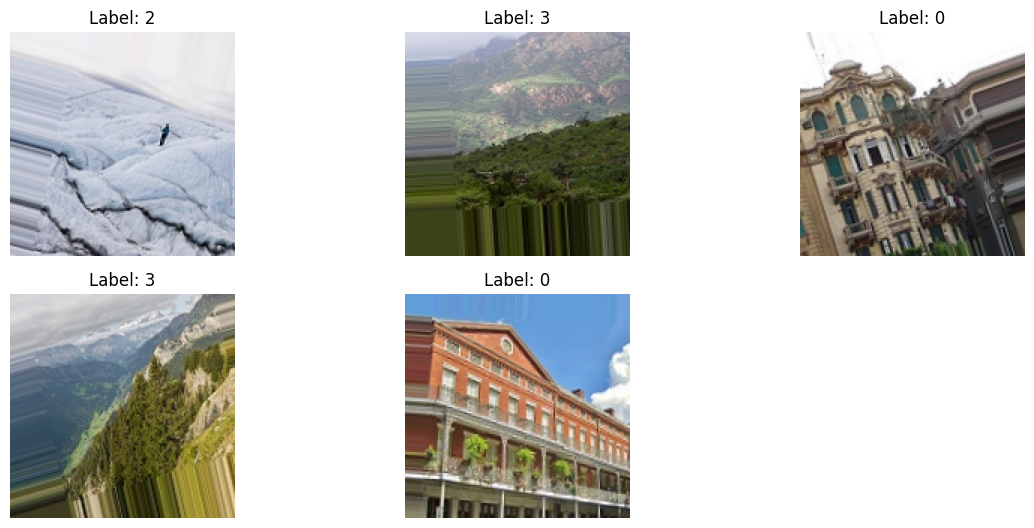

In [23]:
augmented_images, augmented_labels = next(train_generator)  

plt.figure(figsize=(12, 8))
for i in range(5):  
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].astype('uint32'))  
    plt.title(f"Label: {augmented_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### Modeling : ResNet50

In [25]:
def get_labels(generator):
    labels = []
    for _, batch_labels in generator:
        labels.extend(batch_labels)
        if len(labels) >= generator.n:  
            break
    return np.array(labels)


In [26]:
# true_labels = get_labels(test_generator)

# print("True Labels:", true_labels)

In [27]:
def plot_roc_curve(y_true, y_pred, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc


In [28]:
def report_metrics_and_roc(generator, y_true, y_pred, pred_classes, dataset_name="Dataset"):
    print(f"Classification Report for {dataset_name}:")
    print(classification_report(y_true, pred_classes, digits=4))
    
    auc_score = roc_auc_score(y_true, y_pred, multi_class='ovr')
    print(f"AUC Score for {dataset_name}: {auc_score:.4f}")
    
    for i in range(y_pred.shape[1]):
        plot_roc_curve(
            (y_true == i).astype(int), y_pred[:, i], title=f"{dataset_name} ROC Curve (Class {i})"
        )

In [29]:
from sklearn.metrics import auc
def train_model(model, train_generator, val_generator, test_generator, model_name, class_names, epochs=100):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    checkpoint = ModelCheckpoint(
        f'{model_name}_best_model.keras',
        monitor='val_loss', 
        save_best_only=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5, 
        min_lr=1e-7
    )


    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping, checkpoint, reduce_lr],
        verbose=1
    )

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

    train_preds = model.predict(train_generator)
    val_preds = model.predict(val_generator)
    test_preds = model.predict(test_generator)
    
    train_pred_classes = np.argmax(train_preds, axis=1)
    val_pred_classes = np.argmax(val_preds, axis=1)
    test_pred_classes = np.argmax(test_preds, axis=1)


    # ROC_AUC_AND_ALL
    train_labels = get_labels(train_generator)
    val_labels = get_labels(val_generator)
    test_labels = get_labels(test_generator)
    

    # # report_metrics_and_roc(train_generator, train_labels, train_preds, train_pred_classes, "Train")
    report_metrics_and_roc(val_generator, val_labels, val_preds, val_pred_classes, "Validation")
    report_metrics_and_roc(test_generator, test_labels, test_preds, test_pred_classes, "Test")
    
    
    performance = model_metrics(model, test_generator, class_names)

    model.save(f'{model_name}_final_model.keras')
    
    return history, performance


In [30]:
def transfer_learning(base_model_fn, input_shape=(150, 150, 3), num_classes=6):
    base_model = base_model_fn(
        input_shape=input_shape, 
        include_top=False, 
        weights='imagenet'
    )

    for layer in base_model.layers:
        layer.trainable = False
    
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(base_model.input, output)
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

In [31]:
def model_metrics(model, test_generator, class_names):
    print(f'{model}_EVALUATION')
    y_true = y_test
    y_pred_proba = model.predict(test_generator)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
 
    
    cm = confusion_matrix(y_true, y_pred)
    print("\n" + "-"*60)
    print("         Test Confusion Matrix         ")
    print("-"*60 + "\n")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', colorbar=True)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print("-"*60 )
    


    report = classification_report(y_true, y_pred)
    print("\n" + "="*60)
    print("         Test Classification Report         ")
    print("="*60 + "\n")
    print(report)
    print("="*60)
    
    # Per-class metrics
    per_class_precision, per_class_recall, per_class_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )

    
    return {
        'Weighted Precision': precision,
        'Weighted Recall': recall,
        'Weighted F1 Score': f1,
        'AUC': auc,
        'Confusion Matrix': cm,
        'Per Class Precision': per_class_precision,
        'Per Class Recall': per_class_recall,
        'Per Class F1': per_class_f1
    }



### RESNET 50


Training ResNet50...


2024-12-15 16:24:40.413676: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-12-15 16:24:40.413695: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-12-15 16:24:40.413702: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-12-15 16:24:40.413716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 16:24:40.413726: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-12-15 16:24:42.141760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7716 - loss: 1.1029
Epoch 1: val_loss improved from inf to 0.60015, saving model to ResNet50_best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 61s 167ms/step - accuracy: 0.7717 - loss: 1.1024 - val_accuracy: 0.8995 - val_loss: 0.6001 - learning_rate: 1.0000e-04
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8521 - loss: 0.7225
Epoch 2: val_loss improved from 0.60015 to 0.54618, saving model to ResNet50_best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 56s 160ms/step - accuracy: 0.8521 - loss: 0.7224 - val_accuracy: 0.8960 - val_loss: 0.5462 - learning_rate: 1.0000e-04
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8574 - loss: 0.6453
Epoch 3: val_loss improved from 0.54618 to 0.53304, saving model to ResNet50_best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 56s 161ms/step - accuracy: 0.8574 - loss: 0.6453 - val_accuracy: 0.9056 - val_loss: 0.5330 - learning_rate: 1.0000e-04
Epoch 4/100
351/351 ━━━

351/351 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step
Classification Report for Validation:
              precision    recall  f1-score   support

           0     0.9534    0.9338    0.9435       438
           1     0.9782    0.9890    0.9836       454
           2     0.8790    0.8607    0.8697       481
           3     0.8772    0.8807    0.8790       503
           4     0.9512    0.9429    0.9470       455
           5     0.9350    0.9664    0.9504       476

    accuracy                         0.9277      2807
   macro avg     0.9290    0.9289    0.9289      2807
weighted avg     0.9275    0.9277    0.9275      2807

AUC Score for Validation: 0.9925


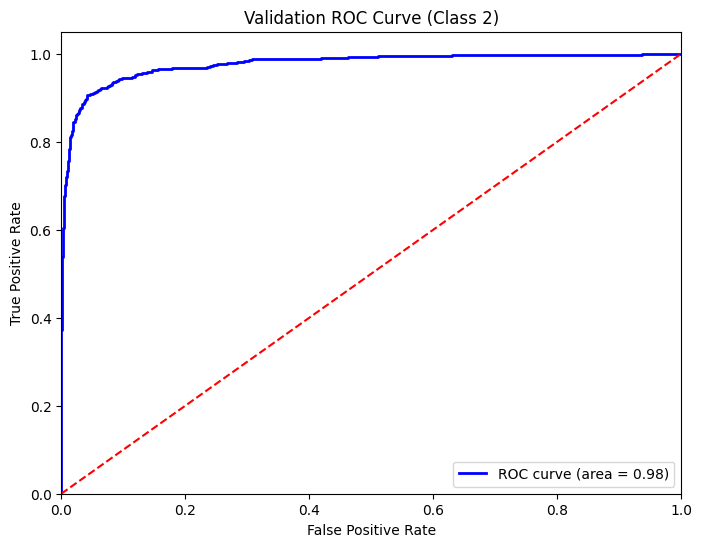

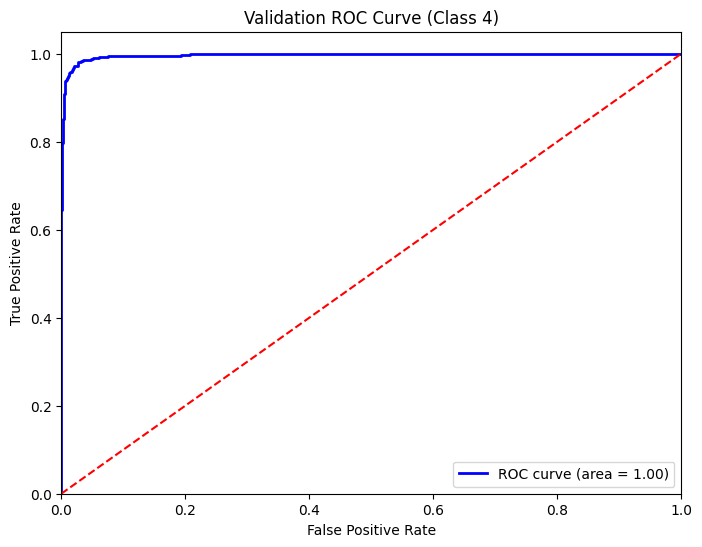

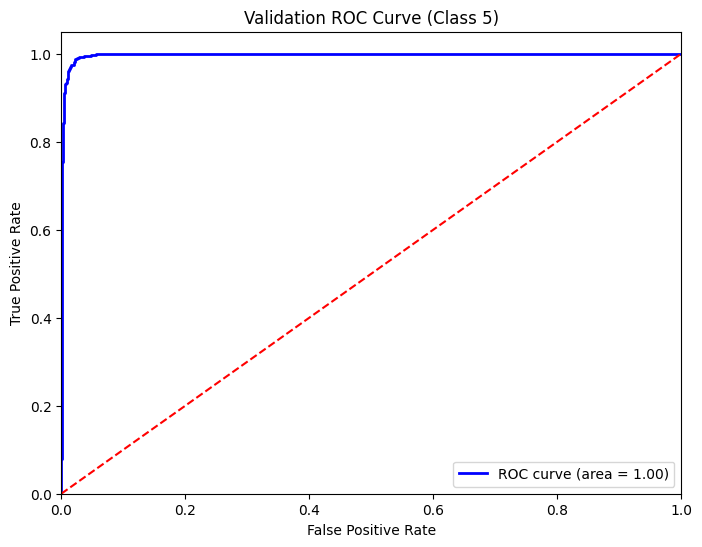

Classification Report for Test:
              precision    recall  f1-score   support

           0     0.9433    0.9130    0.9279       437
           1     0.9895    0.9916    0.9905       474
           2     0.8571    0.8680    0.8625       553
           3     0.8713    0.8514    0.8613       525
           4     0.9412    0.9412    0.9412       510
           5     0.9229    0.9561    0.9392       501

    accuracy                         0.9183      3000
   macro avg     0.9209    0.9202    0.9204      3000
weighted avg     0.9184    0.9183    0.9182      3000

AUC Score for Test: 0.9922


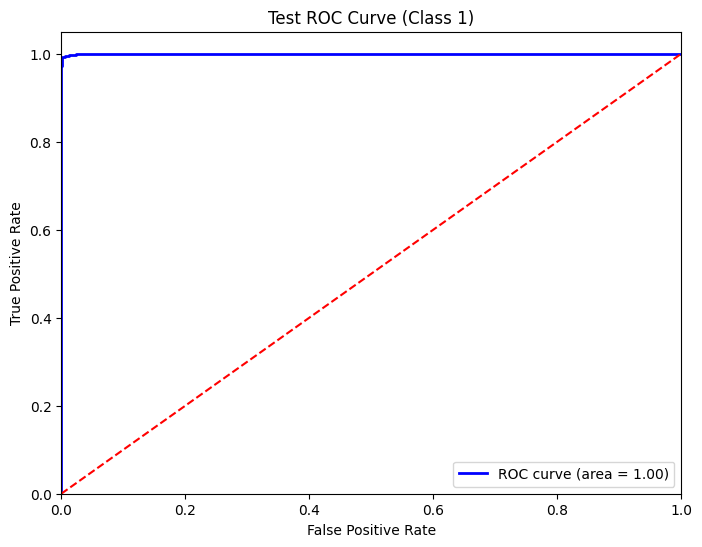

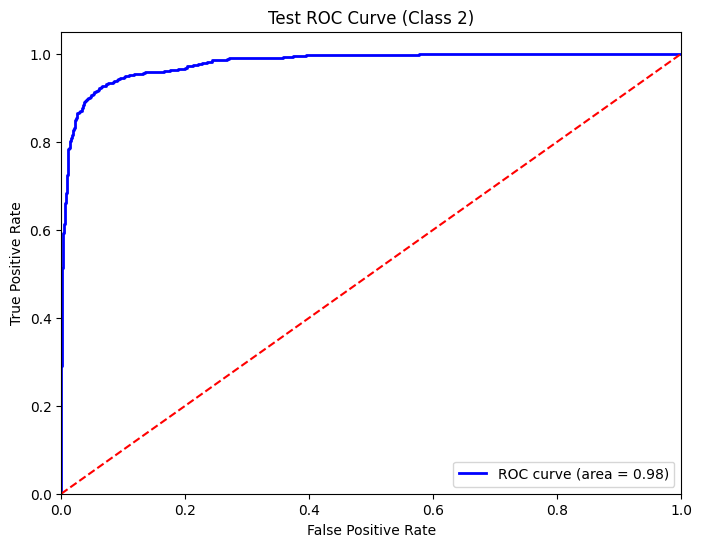

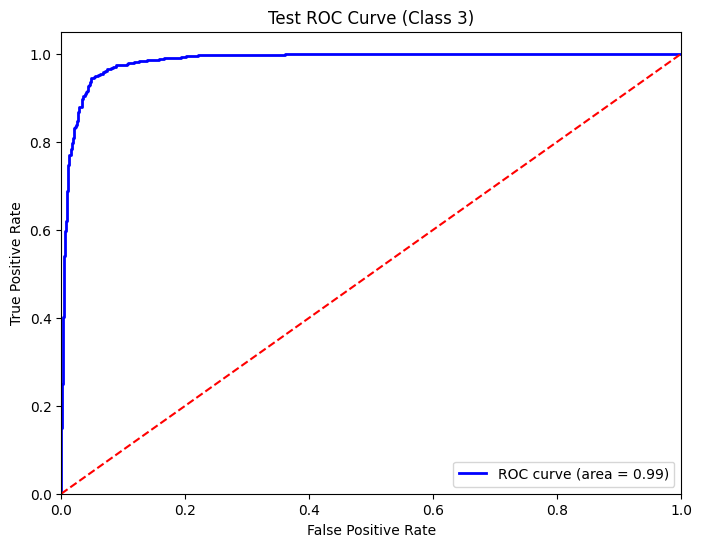

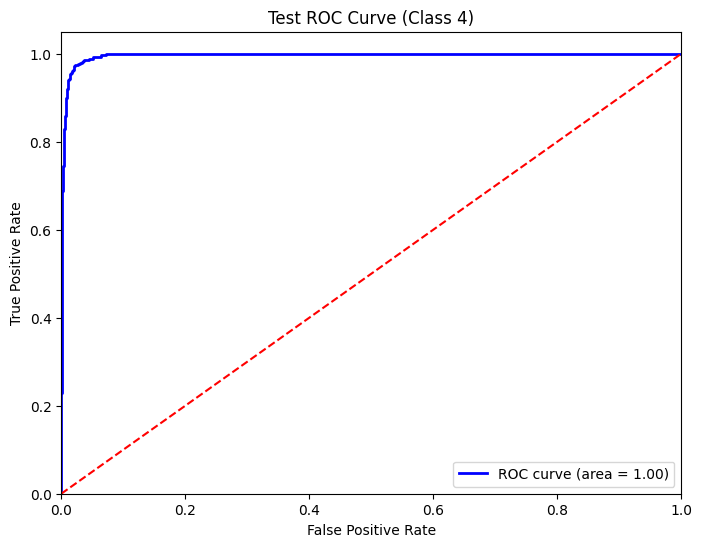

<Functional name=functional, built=True>_EVALUATION
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step

------------------------------------------------------------
         Test Confusion Matrix         
------------------------------------------------------------

Precision: 0.9183532078875087
Recall: 0.9183333333333333
------------------------------------------------------------

         Test Classification Report         

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       437
           1       0.99      0.99      0.99       474
           2       0.86      0.87      0.86       553
           3       0.87      0.85      0.86       525
           4       0.94      0.94      0.94       510
           5       0.92      0.96      0.94       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



In [33]:
model_to_train = [
    {'name': 'ResNet50', 'model': ResNet50},
]

class_names = y_test
op_model_result1 = []


for model_info in model_to_train:
    model_name = model_info['name']
    base_model_fn = model_info['model']
    
    print(f"\nTraining {model_name}...")
    
    model = transfer_learning(base_model_fn)
    
    history, performance = train_model(
        model, 
        train_generator, 
        val_generator, 
        test_generator, 
        model_name, 
        class_names
    )
    train_accuracy = history.history.get('accuracy', None)
    val_accuracy = history.history.get('val_accuracy', None)
    
    result = {
        'Model': model_name,
        'Weighted Precision': performance['Weighted Precision'],
        'Weighted Recall': performance['Weighted Recall'],
        'Weighted F1 Score': performance['Weighted F1 Score'],
        'Best Training Accuracy': train_accuracy,
        'Best Validation Accuracy': val_accuracy,
        'AUC': performance['AUC']
    }
    op_model_result1.append(result)



### RESNET 101


Training ResNet101...
Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7707 - loss: 1.1510
Epoch 1: val_loss improved from inf to 0.60465, saving model to ResNet101_best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 90s 241ms/step - accuracy: 0.7708 - loss: 1.1504 - val_accuracy: 0.9049 - val_loss: 0.6046 - learning_rate: 1.0000e-04
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8547 - loss: 0.7060
Epoch 2: val_loss improved from 0.60465 to 0.54573, saving model to ResNet101_best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 225ms/step - accuracy: 0.8547 - loss: 0.7060 - val_accuracy: 0.9049 - val_loss: 0.5457 - learning_rate: 1.0000e-04
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8642 - loss: 0.6154
Epoch 3: val_loss improved from 0.54573 to 0.51184, saving model to ResNet101_best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 224ms/step - accuracy: 0.8642 - loss: 0.6154 - val_accuracy: 0.9145 - val_loss: 0.5118 - learning_ra

351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 129ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step
Classification Report for Validation:
              precision    recall  f1-score   support

           0     0.9405    0.9384    0.9394       438
           1     0.9869    0.9934    0.9901       454
           2     0.8663    0.8753    0.8707       481
           3     0.8853    0.8748    0.8800       503
           4     0.9506    0.9297    0.9400       455
           5     0.9361    0.9538    0.9448       476

    accuracy                         0.9263      2807
   macro avg     0.9276    0.9275    0.9275      2807
weighted avg     0.9263    0.9263    0.9262      2807

AUC Score for Validation: 0.9928


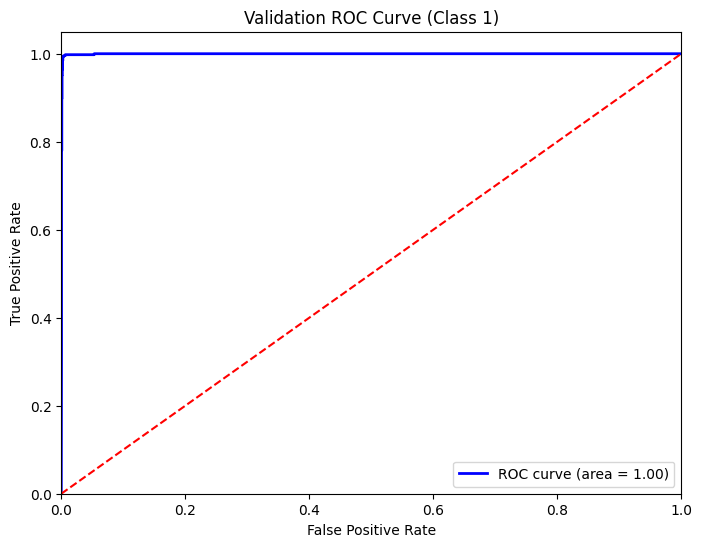

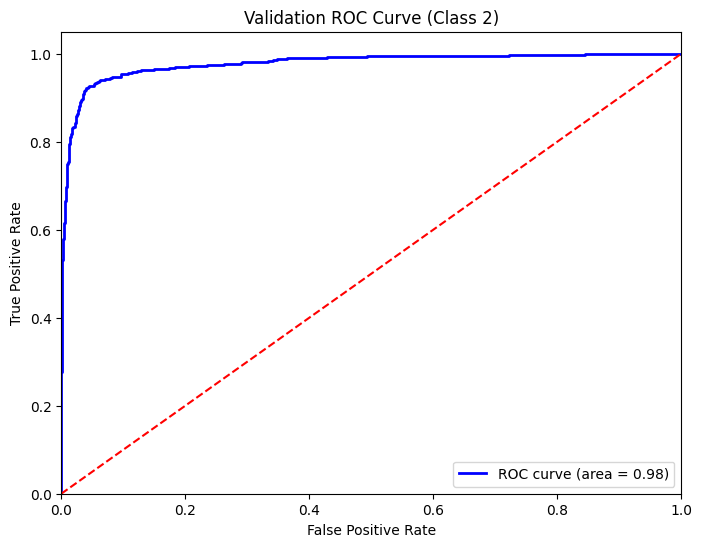

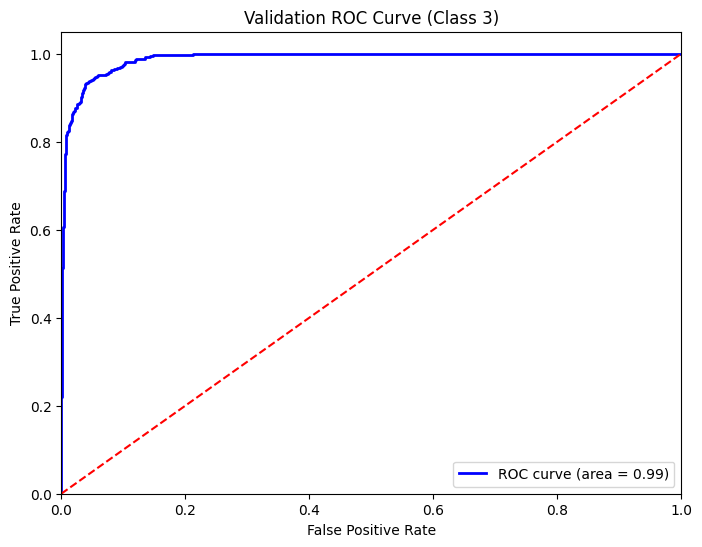

Classification Report for Test:
              precision    recall  f1-score   support

           0     0.9347    0.9176    0.9261       437
           1     0.9894    0.9873    0.9884       474
           2     0.8494    0.8770    0.8630       553
           3     0.8891    0.8400    0.8639       525
           4     0.9282    0.9373    0.9327       510
           5     0.9264    0.9541    0.9400       501

    accuracy                         0.9170      3000
   macro avg     0.9195    0.9189    0.9190      3000
weighted avg     0.9171    0.9170    0.9169      3000

AUC Score for Test: 0.9922


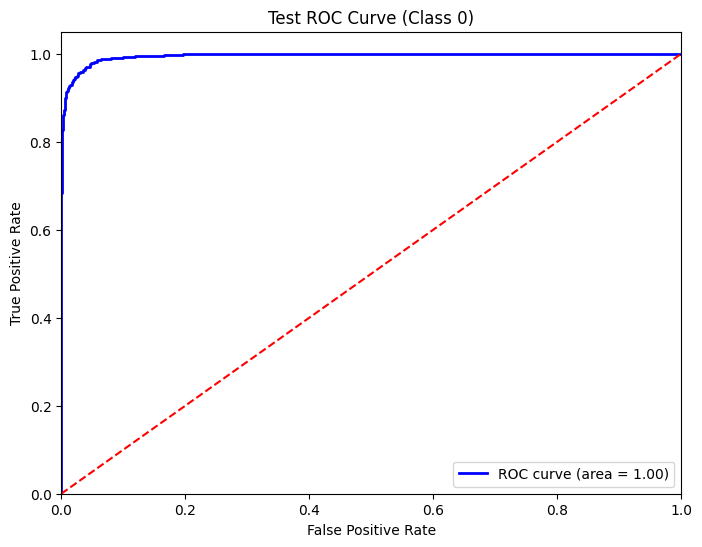

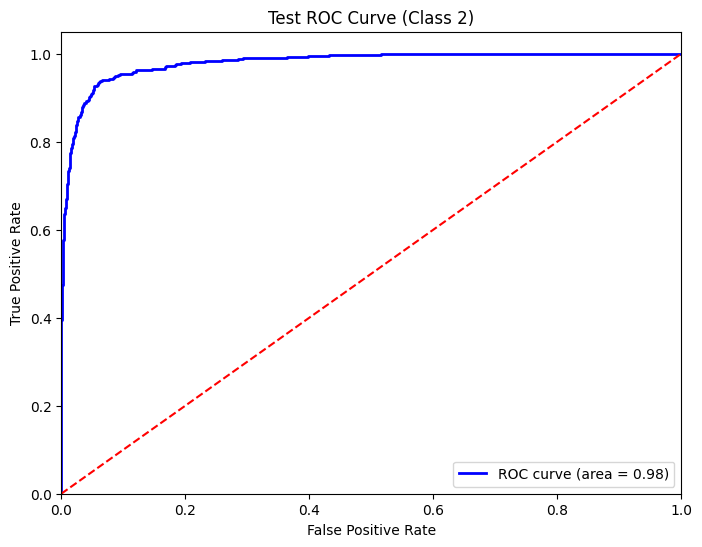

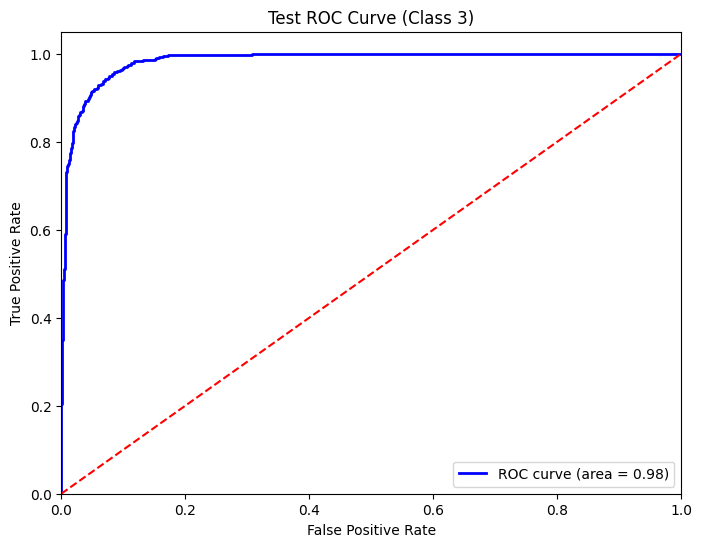

<Functional name=functional_1, built=True>_EVALUATION
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step

------------------------------------------------------------
         Test Confusion Matrix         
------------------------------------------------------------

Precision: 0.9171421555285324
Recall: 0.917
------------------------------------------------------------

         Test Classification Report         

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       437
           1       0.99      0.99      0.99       474
           2       0.85      0.88      0.86       553
           3       0.89      0.84      0.86       525
           4       0.93      0.94      0.93       510
           5       0.93      0.95      0.94       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



In [35]:
model_to_train = [
    {'name': 'ResNet101', 'model': ResNet101},
]

class_names = y_test
op_model_result2 = []

for model_info in model_to_train:
    model_name = model_info['name']
    base_model_fn = model_info['model']
    
    print(f"\nTraining {model_name}...")
    
    model = transfer_learning(base_model_fn)
    
    history, performance = train_model(
        model, 
        train_generator, 
        val_generator, 
        test_generator, 
        model_name, 
        class_names
    )
    train_accuracy = history.history.get('accuracy', None)
    val_accuracy = history.history.get('val_accuracy', None)
    
    result = {
        'Model': model_name,
        'Weighted Precision': performance['Weighted Precision'],
        'Weighted Recall': performance['Weighted Recall'],
        'Weighted F1 Score': performance['Weighted F1 Score'],
        'Best Training Accuracy': train_accuracy,
        'Best Validation Accuracy': val_accuracy,
        'AUC': performance['AUC']
    }
    op_model_result2.append(result)



### EfficientNetB0


Training EfficientNetB0...
Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7990 - loss: 0.9958
Epoch 1: val_loss improved from inf to 0.59928, saving model to EfficientNetB0_best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 132ms/step - accuracy: 0.7992 - loss: 0.9954 - val_accuracy: 0.9013 - val_loss: 0.5993 - learning_rate: 1.0000e-04
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8736 - loss: 0.6457
Epoch 2: val_loss improved from 0.59928 to 0.47544, saving model to EfficientNetB0_best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.8736 - loss: 0.6457 - val_accuracy: 0.9216 - val_loss: 0.4754 - learning_rate: 1.0000e-04
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8802 - loss: 0.6022
Epoch 3: val_loss did not improve from 0.47544
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step - accuracy: 0.8802 - loss: 0.6022 - val_accuracy: 0.9149 - val_loss: 0.4825 - learning_rate: 1.0000e-04
Epoch 4/100
351/351 

351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step
Classification Report for Validation:
              precision    recall  f1-score   support

           0     0.9627    0.9429    0.9527       438
           1     0.9890    0.9934    0.9912       454
           2     0.8789    0.8753    0.8771       481
           3     0.9008    0.8847    0.8927       503
           4     0.9565    0.9670    0.9617       455
           5     0.9448    0.9706    0.9575       476

    accuracy                         0.9377      2807
   macro avg     0.9388    0.9390    0.9388      2807
weighted avg     0.9375    0.9377    0.9375      2807

AUC Score for Validation: 0.9945


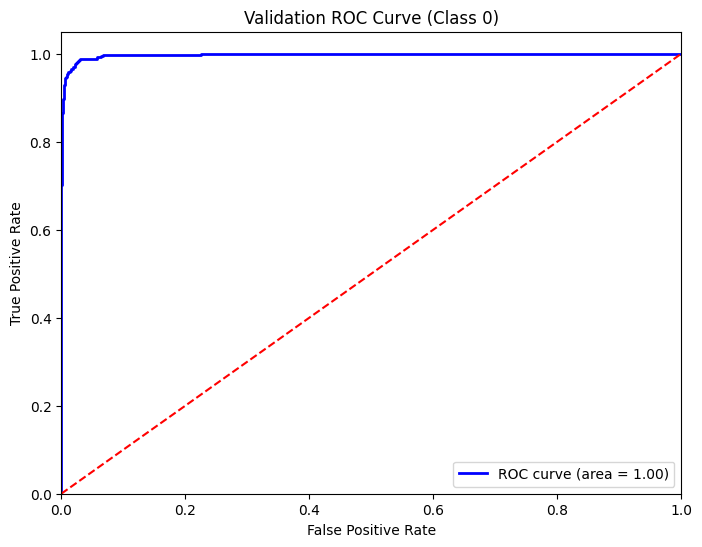

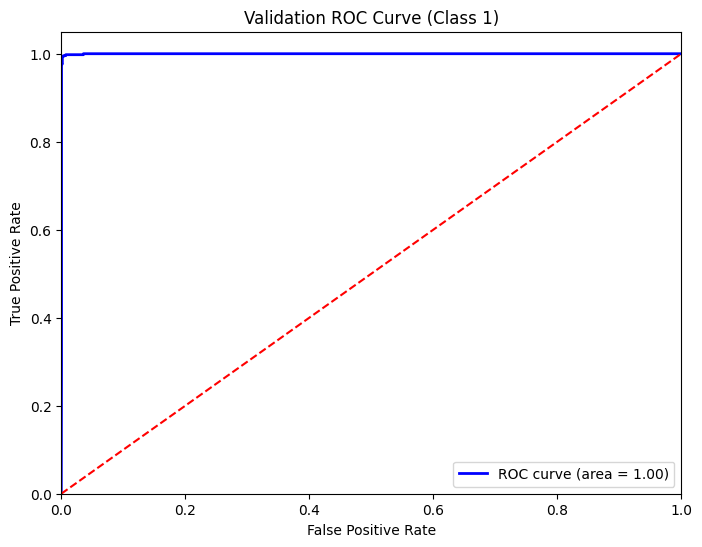

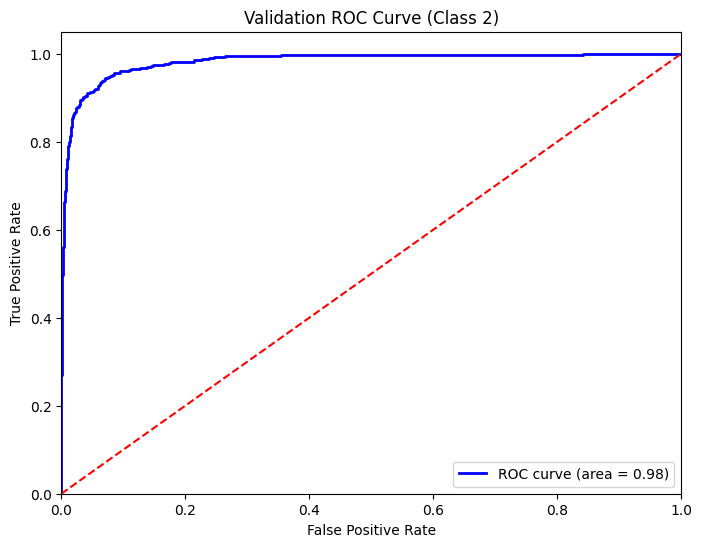

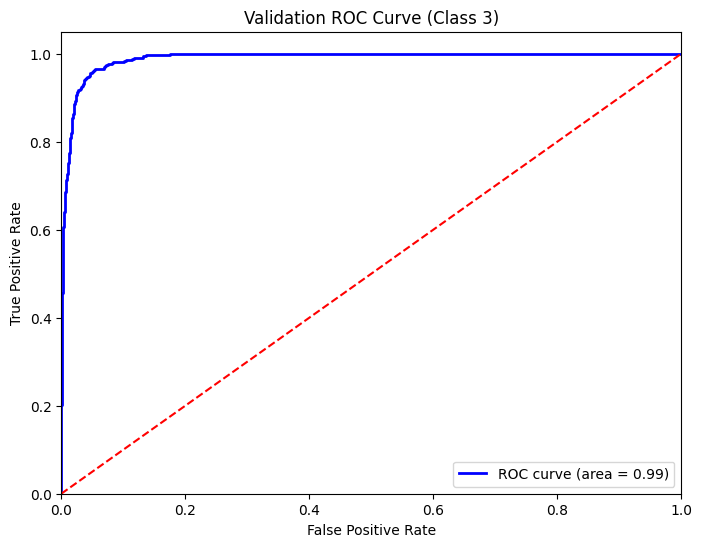

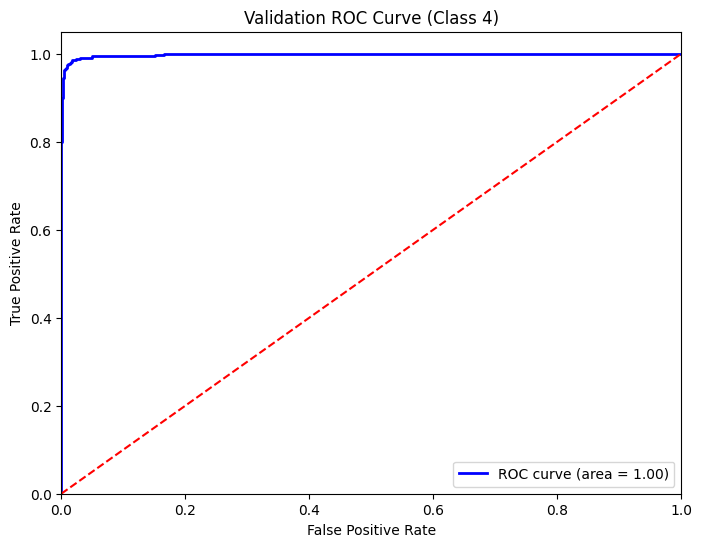

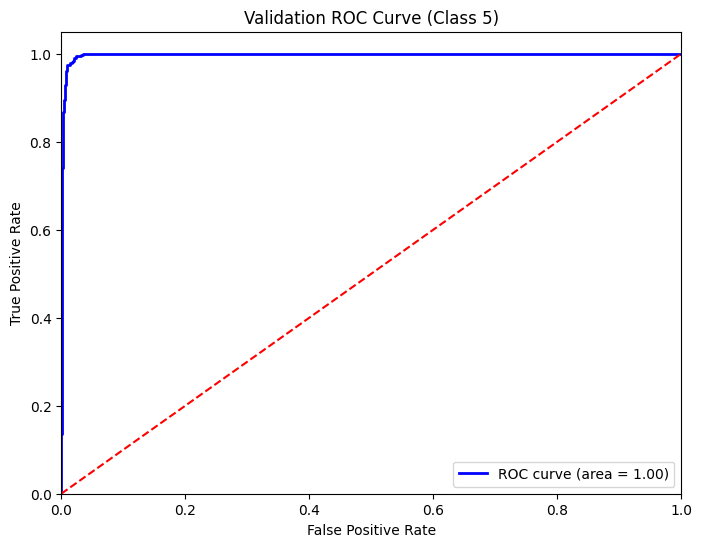

Classification Report for Test:
              precision    recall  f1-score   support

           0     0.9259    0.9153    0.9206       437
           1     0.9979    0.9937    0.9958       474
           2     0.8803    0.8644    0.8723       553
           3     0.8793    0.8743    0.8768       525
           4     0.9483    0.9706    0.9593       510
           5     0.9273    0.9421    0.9347       501

    accuracy                         0.9250      3000
   macro avg     0.9265    0.9267    0.9266      3000
weighted avg     0.9248    0.9250    0.9248      3000

AUC Score for Test: 0.9941


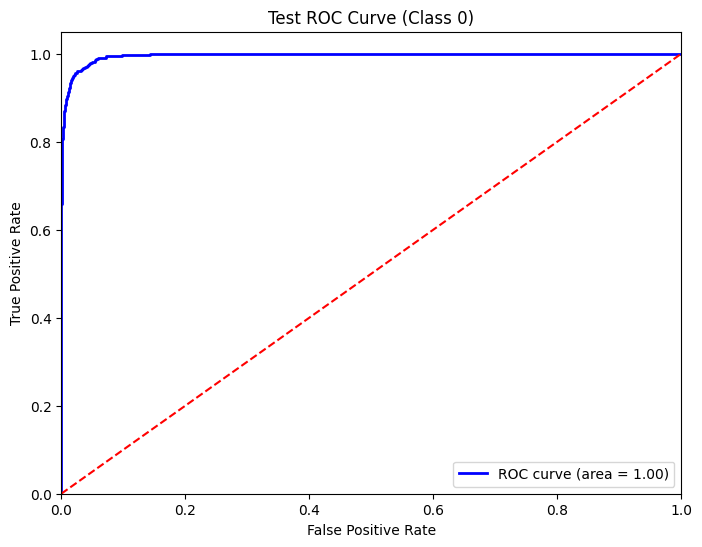

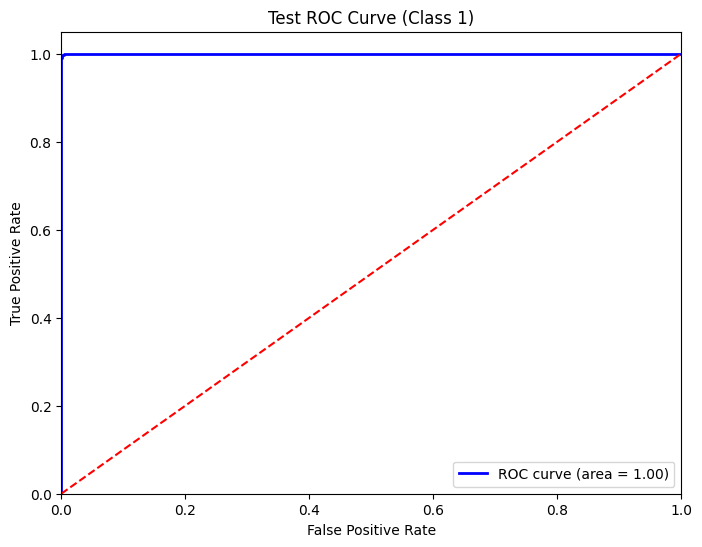

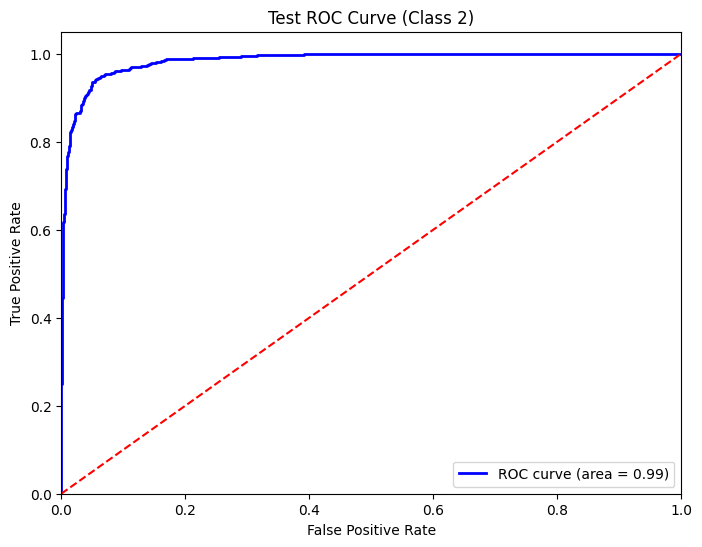

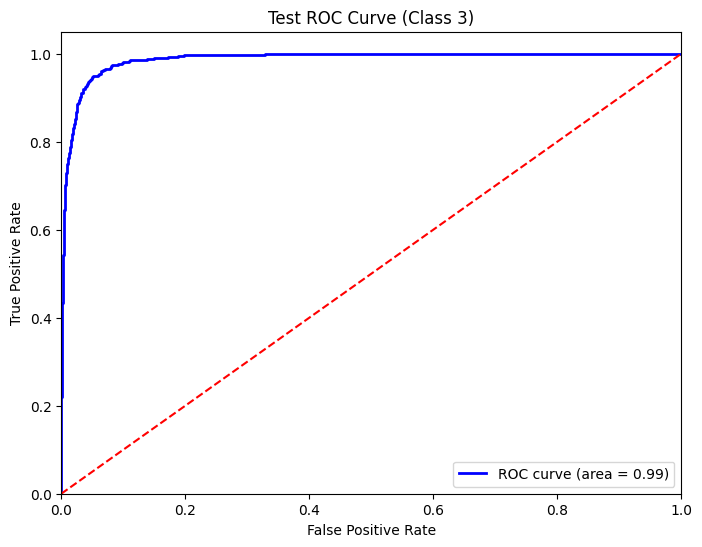

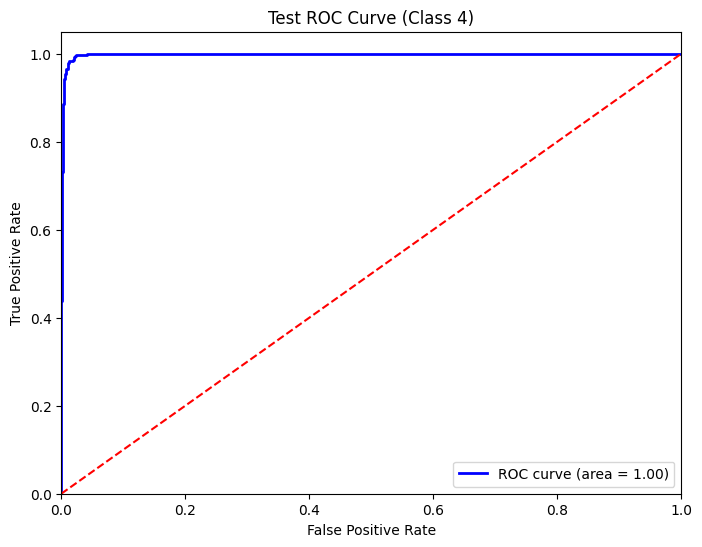

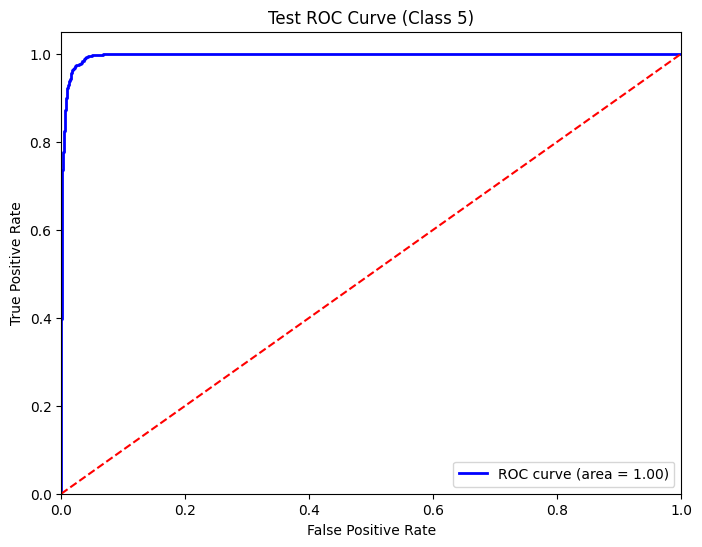

<Functional name=functional_2, built=True>_EVALUATION
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step

------------------------------------------------------------
         Test Confusion Matrix         
------------------------------------------------------------

Precision: 0.9247561640135513
Recall: 0.925
------------------------------------------------------------

         Test Classification Report         

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       437
           1       1.00      0.99      1.00       474
           2       0.88      0.86      0.87       553
           3       0.88      0.87      0.88       525
           4       0.95      0.97      0.96       510
           5       0.93      0.94      0.93       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.92      0.93      0.92      3000



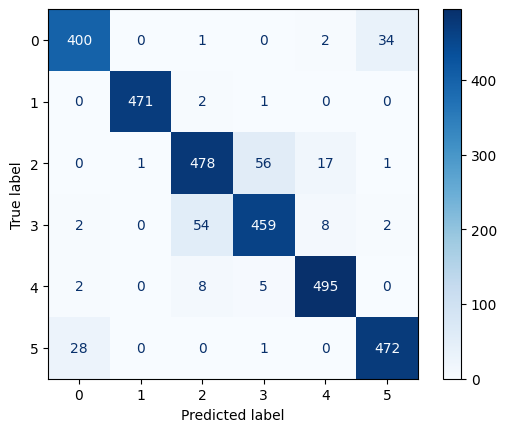

In [37]:
model_to_train = [
    {'name': 'EfficientNetB0', 'model': EfficientNetB0},
]

class_names = y_test


op_model_result3 = []


for model_info in model_to_train:
    model_name = model_info['name']
    base_model_fn = model_info['model']
    
    print(f"\nTraining {model_name}...")

    model = transfer_learning(base_model_fn)
    

    history, performance = train_model(
        model, 
        train_generator, 
        val_generator, 
        test_generator, 
        model_name, 
        class_names
    )
    train_accuracy = history.history.get('accuracy', None)
    val_accuracy = history.history.get('val_accuracy', None)
    

    result = {
        'Model': model_name,
        'Weighted Precision': performance['Weighted Precision'],
        'Weighted Recall': performance['Weighted Recall'],
        'Weighted F1 Score': performance['Weighted F1 Score'],
        'Best Training Accuracy': train_accuracy,
        'Best Validation Accuracy': val_accuracy,
        'AUC': performance['AUC']
    }
    op_model_result3.append(result)



### VGG16


Training VGG16...
Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6830 - loss: 1.2487
Epoch 1: val_loss improved from inf to 0.59034, saving model to VGG16_best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step - accuracy: 0.6832 - loss: 1.2479 - val_accuracy: 0.8785 - val_loss: 0.5903 - learning_rate: 1.0000e-04
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8147 - loss: 0.8300
Epoch 2: val_loss improved from 0.59034 to 0.55569, saving model to VGG16_best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - accuracy: 0.8147 - loss: 0.8299 - val_accuracy: 0.8906 - val_loss: 0.5557 - learning_rate: 1.0000e-04
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8373 - loss: 0.7101
Epoch 3: val_loss improved from 0.55569 to 0.55550, saving model to VGG16_best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - accuracy: 0.8373 - loss: 0.7102 - val_accuracy: 0.8878 - val_loss: 0.5555 - learning_rate: 1.0000e-04
Epoc

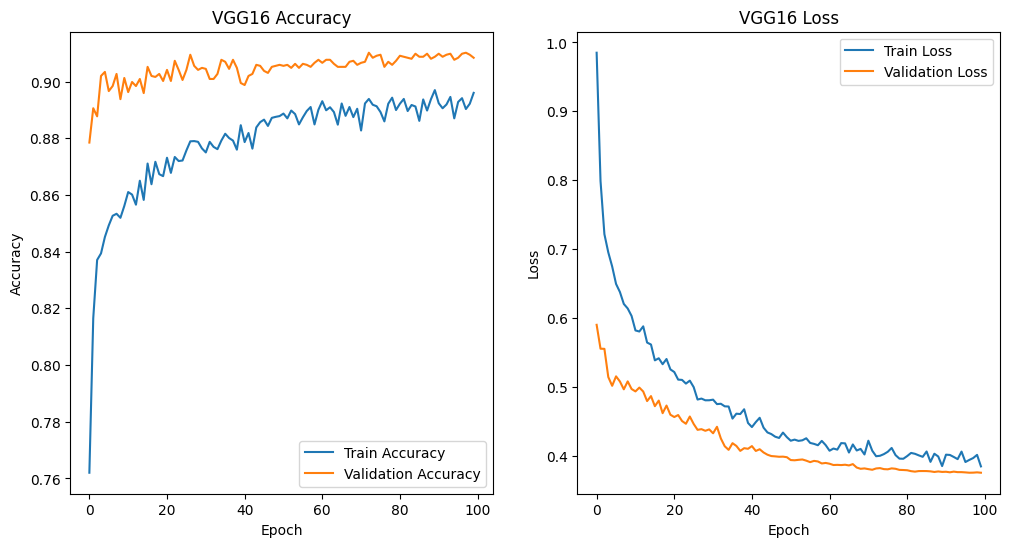

351/351 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step
Classification Report for Validation:
              precision    recall  f1-score   support

           0     0.9154    0.9384    0.9267       438
           1     0.9847    0.9956    0.9901       454
           2     0.8636    0.8295    0.8462       481
           3     0.8389    0.8489    0.8439       503
           4     0.9132    0.9253    0.9192       455
           5     0.9422    0.9244    0.9332       476

    accuracy                         0.9084      2807
   macro avg     0.9097    0.9103    0.9099      2807
weighted avg     0.9082    0.9084    0.9082      2807

AUC Score for Validation: 0.9897


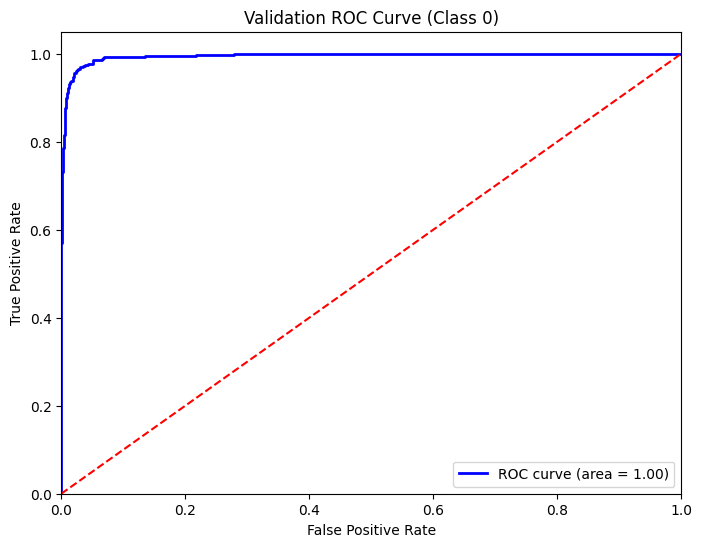

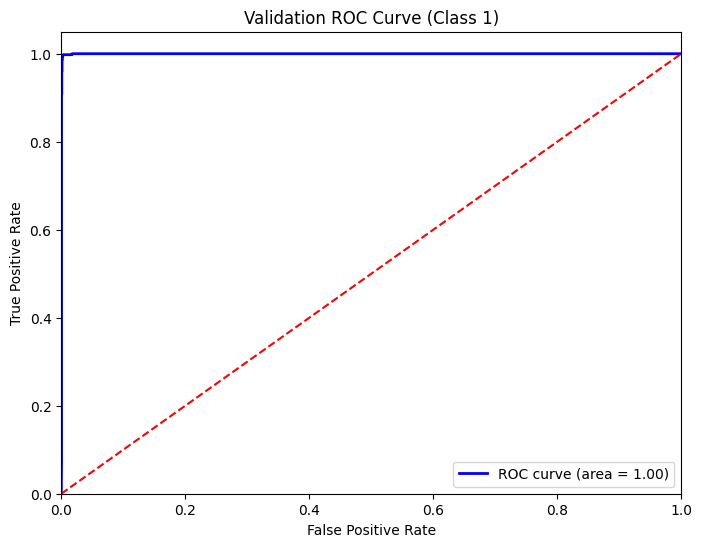

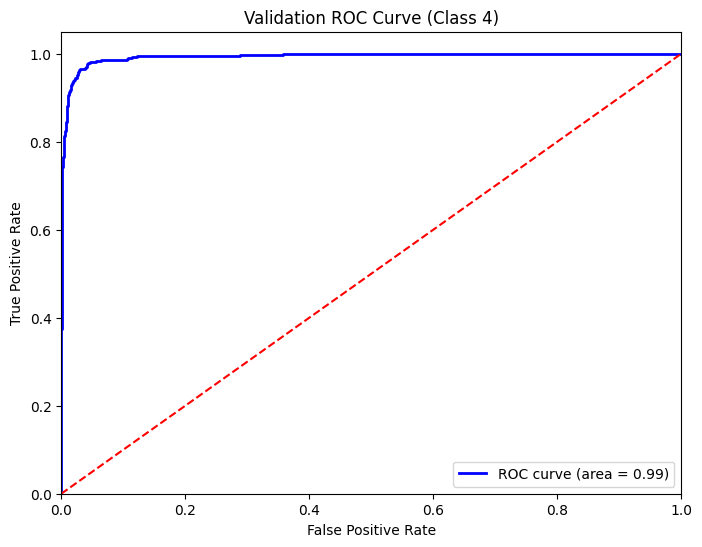

Classification Report for Test:
              precision    recall  f1-score   support

           0     0.9114    0.9176    0.9145       437
           1     0.9832    0.9873    0.9853       474
           2     0.8616    0.8445    0.8530       553
           3     0.8459    0.8362    0.8410       525
           4     0.9138    0.9353    0.9244       510
           5     0.9202    0.9202    0.9202       501

    accuracy                         0.9043      3000
   macro avg     0.9060    0.9068    0.9064      3000
weighted avg     0.9040    0.9043    0.9041      3000

AUC Score for Test: 0.9892


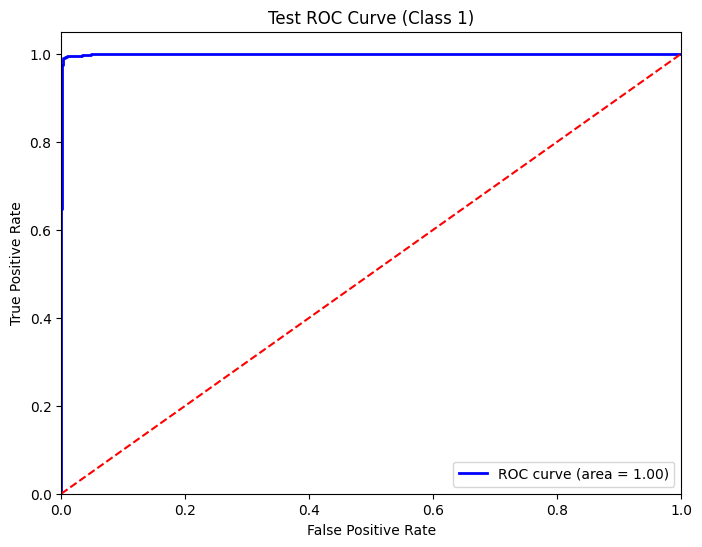

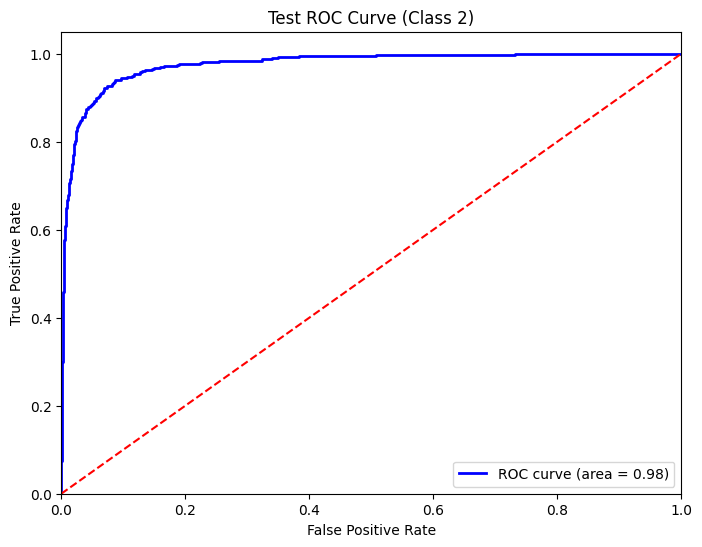

<Functional name=functional_3, built=True>_EVALUATION
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step

------------------------------------------------------------
         Test Confusion Matrix         
------------------------------------------------------------

Precision: 0.9039623365273921
Recall: 0.9043333333333333
------------------------------------------------------------

         Test Classification Report         

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       437
           1       0.98      0.99      0.99       474
           2       0.86      0.84      0.85       553
           3       0.85      0.84      0.84       525
           4       0.91      0.94      0.92       510
           5       0.92      0.92      0.92       501

    accuracy                           0.90      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.90      0.90      0.90      3000



In [39]:
model_to_train = [
    {'name': 'VGG16', 'model': VGG16}
]

class_names = y_test

op_model_result4 = []

for model_info in model_to_train:
    model_name = model_info['name']
    base_model_fn = model_info['model']
    
    print(f"\nTraining {model_name}...")
    
    model = transfer_learning(base_model_fn)
    
    history, performance = train_model(
        model, 
        train_generator, 
        val_generator, 
        test_generator, 
        model_name, 
        class_names
    )
    train_accuracy = history.history.get('accuracy', None)
    val_accuracy = history.history.get('val_accuracy', None)
    
 
    result = {
        'Model': model_name,
        'Weighted Precision': performance['Weighted Precision'],
        'Weighted Recall': performance['Weighted Recall'],
        'Weighted F1 Score': performance['Weighted F1 Score'],
        'Best Training Accuracy': train_accuracy,
        'Best Validation Accuracy': val_accuracy,
        'AUC': performance['AUC']
    }
    op_model_result4.append(result)



### Train and Validation Accuracy Comparison:

In [40]:
op_model_result1_df = pd.DataFrame(op_model_result1)
op_model_result2_df = pd.DataFrame(op_model_result2)
op_model_result3_df = pd.DataFrame(op_model_result3)
op_model_result4_df = pd.DataFrame(op_model_result4)

op_model_result_df = pd.concat([op_model_result1_df, op_model_result2_df, op_model_result3_df, op_model_result4_df], axis=0, ignore_index=True)
op_model_result_df


Model  Weighted Precision  Weighted Recall  Weighted F1 Score  \
0        ResNet50            0.918353         0.918333           0.918232   
1       ResNet101            0.917142         0.917000           0.916859   
2  EfficientNetB0            0.924756         0.925000           0.924826   
3           VGG16            0.903962         0.904333           0.904104   

                              Best Training Accuracy  \
0  [0.8117929697036743, 0.8517858982086182, 0.858...   
1  [0.813040018081665, 0.8541907668113708, 0.8618...   
2  [0.8396722078323364, 0.8715596199035645, 0.880...   
3  [0.7620022892951965, 0.8165137767791748, 0.837...   

                            Best Validation Accuracy  \
0  [0.8995368480682373, 0.895974338054657, 0.9055...   
1  [0.9048806428909302, 0.9048806428909302, 0.914...   
2  [0.9013181328773499, 0.921624481678009, 0.9148...   
3  [0.8785179853439331, 0.8906305432319641, 0.887...   

                             AUC  
0  <function auc at 0x308615ea0>  
1  <function auc at 0x308615ea0>  
2  <function auc at 0x308615ea0>  
3  <function auc at 0x308615ea0>

In [41]:
op_model_result_df = pd.concat([op_model_result1_df, op_model_result2_df, op_model_result3_df, op_model_result4_df], axis=0, ignore_index=True)
op_model_result_df['Best Training Accuracy'] = op_model_result_df['Best Training Accuracy'].apply(max)
op_model_result_df['Best Validation Accuracy'] = op_model_result_df['Best Validation Accuracy'].apply(max)
print("\nModel Performance op_model_result:")
op_model_result_df = op_model_result_df.drop(columns=['AUC'])
for col in op_model_result_df.columns[1:]:  
    op_model_result_df[col] = op_model_result_df[col].map(lambda x: f"{round(x * 100, 2)}%")

op_model_result_df



Model Performance op_model_result:


Model Weighted Precision Weighted Recall Weighted F1 Score  \
0        ResNet50             91.84%          91.83%            91.82%   
1       ResNet101             91.71%           91.7%            91.69%   
2  EfficientNetB0             92.48%           92.5%            92.48%   
3           VGG16              90.4%          90.43%            90.41%   

  Best Training Accuracy Best Validation Accuracy  
0                 94.01%                   92.87%  
1                 93.33%                    92.8%  
2                 94.34%                   93.77%  
3                  89.7%                   91.02%

### Test Accuracy Comaparison

In [96]:
from tensorflow.keras.models import load_model

model_directory = "../Data_f/"  
model_files = glob.glob(f"{model_directory}*_best_model.keras")
test_accuracies = {}


for model_file in model_files:
    print(f"Loading model: {model_file}")
    model = load_model(model_file)
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    model_name = model_file.split('/')[-1].replace('_best_model.keras', '')
    test_accuracies[model_name] = test_accuracy

print("\nTest Accuracies for Saved Models:")
for model_name, accuracy in test_accuracies.items():
    print(f"{model_name}: {accuracy:.4f}")


Loading model: ../Data_f/VGG16_best_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9120 - loss: 0.3650
Loading model: ../Data_f/ResNet50_best_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.9224 - loss: 0.3231
Loading model: ../Data_f/ResNet101_best_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step - accuracy: 0.9259 - loss: 0.3420
Loading model: ../Data_f/EfficientNetB0_best_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.9308 - loss: 0.2719

Test Accuracies for Saved Models:
VGG16: 0.9043
ResNet50: 0.9183
ResNet101: 0.9170
EfficientNetB0: 0.9250


### EfficientNetB0 performs best overall based on f1-score, precision and recall and also overall accuracy